# Import Libraries


In [93]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
import seaborn as sns

from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn import metrics

import lightgbm as lgb

from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression

# Import Dataset

In [4]:
#Import Data
data = pd.read_csv('/Users/user/Desktop/BootCamp/Dataset/fraud.csv')
data_copy = data.copy()

# Data Cleaning

# Features
step: represents a unit of time where 1 step equals 1 hour

type: type of online transaction

amount: the amount of the transaction

nameOrig: customer starting the transaction

oldbalanceOrg: balance before the transaction

newbalanceOrig: balance after the transaction

nameDest: recipient of the transaction

oldbalanceDest: initial balance of recipient before the transaction

newbalanceDest: the new balance of recipient after the transaction

isFraud: fraud transaction

In [5]:
data.head()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,0
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1,0
3,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1,0
4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0,0


In [6]:
encoder = LabelEncoder()
data['type'] = encoder.fit_transform(data['type'])

In [7]:
data.describe().round(2)

,step,type,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
count,6362620.00,6362620.00,6362620.00,6362620.00,6362620.00,6.362620e+06,6.362620e+06,6362620.00,6362620.0
mean,243.40,1.71,179861.90,833883.10,855113.67,1.100702e+06,1.224996e+06,0.00,0.0
std,142.33,1.35,603858.23,2888242.67,2924048.50,3.399180e+06,3.674129e+06,0.04,0.0
min,1.00,0.00,0.00,0.00,0.00,0.000000e+00,0.000000e+00,0.00,0.0
25%,156.00,1.00,13389.57,0.00,0.00,0.000000e+00,0.000000e+00,0.00,0.0
50%,239.00,1.00,74871.94,14208.00,0.00,1.327057e+05,2.146614e+05,0.00,0.0
75%,335.00,3.00,208721.48,107315.18,144258.41,9.430367e+05,1.111909e+06,0.00,0.0
max,743.00,4.00,92445516.64,59585040.37,49585040.37,3.560159e+08,3.561793e+08,1.00,1.0


In [8]:
data.isnull().sum()

step              0
type              0
amount            0
nameOrig          0
oldbalanceOrg     0
newbalanceOrig    0
nameDest          0
oldbalanceDest    0
newbalanceDest    0
isFraud           0
isFlaggedFraud    0
dtype: int64

In [9]:
(data==0).sum()

step                    0
type              1399284
amount                 16
nameOrig                0
oldbalanceOrg     2102449
newbalanceOrig    3609566
nameDest                0
oldbalanceDest    2704388
newbalanceDest    2439433
isFraud           6354407
isFlaggedFraud    6362604
dtype: int64

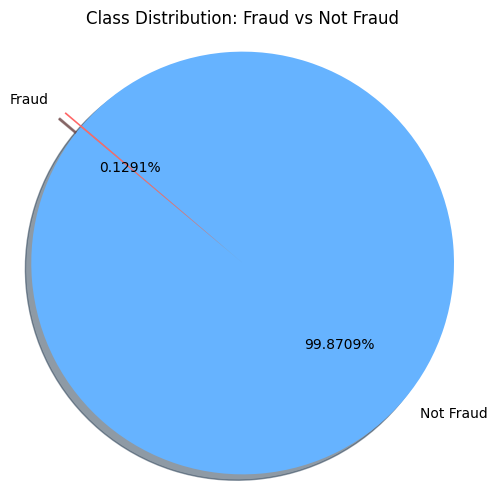

In [ ]:
# Class_Imbalance

# Count each class
class_counts = data_copy['isFraud'].value_counts()
labels = ['Not Fraud', 'Fraud']
colors = ['#66b3ff', '#ff6666']
explode = (0, 0.1)  # Slightly separate the fraud slice for emphasis

# Plot pie chart
plt.figure(figsize=(6, 6))
plt.pie(
    class_counts,
    labels=labels,
    autopct='%1.4f%%',  # Show percentage with 4 decimal places
    startangle=140,
    colors=colors,
    explode=explode,
    shadow=True
)
plt.title('Class Distribution: Fraud vs Not Fraud')
plt.axis('equal')  # Equal aspect ratio ensures pie is drawn as a circle
plt.show()


# Indicate outliers and corrolation



In [ ]:
features = data_copy.drop(['isFraud','nameOrig', 'nameDest'], axis=1)


fig, ax = plt.subplots(nrows=3,ncols=3)
ax = ax.flatten()

for i,feature in enumerate(features.columns):
    ax[i].boxplot(data_copy[feature])
    ax[i].set_title(feature)


plt.tight_layout()
plt.show()
    




# Feature Engineering
1. Number of Past Transactions (per sender)
2. Time Since Last Transaction (per sender)
3. Average Past Transaction Amount
4. Total Past Amount Transferred
5. Incoming vs. Outgoing Transaction Ratio






In [10]:
# 1. Number of Past Transactions (per sender)

# Sort the data by sender and step
data = data.sort_values(by=['nameOrig', 'step'], ascending=True)

# For each sender, count how many previous transactions they have made
data['hist_per_sender'] = data.groupby('nameOrig').cumcount()


In [11]:
#2. Time Since Last Transaction (per sender)

data = data.sort_values(by=['nameOrig', 'step'])

# Get the previous transaction time (step) per sender (nameOrig)
data['prev_step'] = data.groupby('nameOrig')['step'].shift(1)

# Create a flag: 1 if it's the first transaction (no previous step), else 0
data['is_first_txn'] = data['prev_step'].isna().astype(int)

# Replace NaN in prev_step with 0 to allow arithmetic operations
data['prev_step'] = data['prev_step'].fillna(0)

# Calculate time difference between current and previous transaction per sender
data['time_since_last'] = data['step'] - data['prev_step']






In [12]:
# 3. 🔄 Average Past Transaction Amount
data = data.sort_values(by=['nameOrig', 'step'])
data['AVG_txn_amount'] = data.groupby('nameOrig')['amount'].transform('mean')

In [13]:
#total amount transferred before the current transaction”
data['total_past_amount'] = data.groupby('nameOrig')['amount'].cumsum().shift(1).fillna(0)


In [14]:
# 5. 🔁 Incoming vs. Outgoing Transaction Ratio

# 4. 💰 Total Past Amount Transferred
data = data.sort_values(by=['nameOrig', 'step'])
data['total_amount'] = data.groupby('nameOrig')['amount'].transform('sum')



✅ Objective:
We want to compute, for each customer, this ratio:

in_out_ratio = total_received / (total_sent + 1e-6)

This helps us understand:

Do they mostly receive money?

Or mostly send money?

High ratios (e.g., 1000+) might indicate mule accounts or suspicious behavior.

In [16]:


# 1. Tag outgoing and incoming transactions
data['is_outgoing'] = data['nameOrig'].str.startswith('C')  # Customers sending money
data['is_incoming'] = data['nameDest'].str.startswith('C')  # Customers receiving money

# 2. Total amount sent per customer (as sender)
total_sent = data[data['is_outgoing']] \
    .groupby('nameOrig')['amount'] \
    .sum() \
    .rename('total_sent')

# 3. Total amount received per customer (as receiver)
total_received = data[data['is_incoming']] \
    .groupby('nameDest')['amount'] \
    .sum() \
    .rename('total_received')

# 4. Combine both into one DataFrame, align by customer ID
user_flow = pd.concat([total_sent, total_received], axis=1).fillna(0)

# 5. Calculate Incoming vs Outgoing Ratio (avoid division by zero)
user_flow['in_out_ratio'] = user_flow['total_received'] / (user_flow['total_sent'] + 1e-6)

# 6. (Optional) Merge back into the original dataset, based on sender
data = data.merge(user_flow['in_out_ratio'], how='left', left_on='nameOrig', right_index=True)


In [18]:
# How much balance changes — but not using post-transaction balance
data['balance_change'] = data['oldbalanceOrg'] - data['amount']

# Was the transaction even possible?
data['insufficient_funds'] = (data['oldbalanceOrg'] < data['amount']).astype(int)


In [19]:
data.head()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,...,is_first_txn,time_since_last,AVG_txn_amount,total_past_amount,total_amount,is_outgoing,is_incoming,in_out_ratio,balance_change,insufficient_funds
3196942,249,1,244486.46,C1000000639,8946.00,0.00,C785826240,526950.37,771436.84,0,...,1,249.0,244486.46,0.00,244486.46,True,True,0.0,-235540.46,1
2798983,217,3,3170.28,C1000001337,58089.00,54918.72,M216466820,0.00,0.00,0,...,1,217.0,3170.28,244486.46,3170.28,True,False,0.0,54918.72,0
1013585,46,3,8424.74,C1000001725,783.00,0.00,M1974356374,0.00,0.00,0,...,1,46.0,8424.74,3170.28,8424.74,True,False,0.0,-7641.74,1
2980283,231,0,261877.19,C1000002591,7596.00,269473.19,C503690069,1126627.70,864750.51,0,...,1,231.0,261877.19,8424.74,261877.19,True,True,0.0,-254281.19,1
1920204,167,0,20528.65,C1000003372,2302074.12,2322602.77,C1840417793,82696.17,62167.52,0,...,1,167.0,20528.65,261877.19,20528.65,True,True,0.0,2281545.47,0


# Check corrolation after feature engineering


<Axes: >

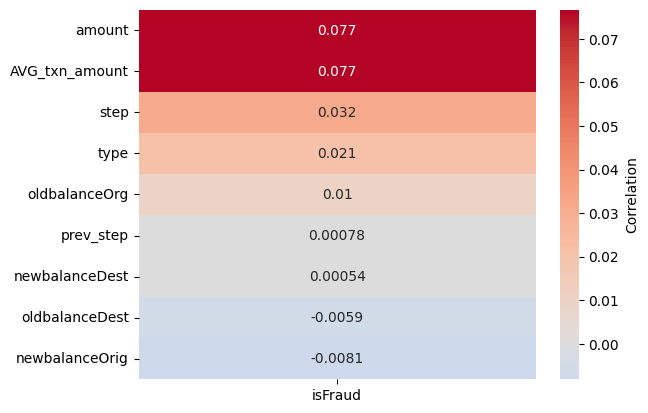

In [56]:
#features = data.drop(columns=['nameOrig','nameDest','is_outgoing','is_incoming','is_first_txn','isFlaggedFraud','isFraud'])
features = ['step', 'type','amount','oldbalanceOrg','newbalanceOrig','oldbalanceDest','newbalanceDest','prev_step','AVG_txn_amount','isFraud']
corr = data[features].corr()['isFraud'].drop('isFraud').sort_values(ascending=False)
sns.heatmap(
            corr.to_frame(),
            center=0,
            annot=True,
            cmap='coolwarm',
            cbar_kws= {'label': 'Correlation'} 
            
            )

In [66]:
data.head()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,...,is_first_txn,time_since_last,AVG_txn_amount,total_past_amount,total_amount,is_outgoing,is_incoming,in_out_ratio,balance_change,insufficient_funds
3196942,249,1,244486.46,C1000000639,8946.00,0.00,C785826240,526950.37,771436.84,0,...,1,249.0,244486.46,0.00,244486.46,True,True,0.0,-235540.46,1
2798983,217,3,3170.28,C1000001337,58089.00,54918.72,M216466820,0.00,0.00,0,...,1,217.0,3170.28,244486.46,3170.28,True,False,0.0,54918.72,0
1013585,46,3,8424.74,C1000001725,783.00,0.00,M1974356374,0.00,0.00,0,...,1,46.0,8424.74,3170.28,8424.74,True,False,0.0,-7641.74,1
2980283,231,0,261877.19,C1000002591,7596.00,269473.19,C503690069,1126627.70,864750.51,0,...,1,231.0,261877.19,8424.74,261877.19,True,True,0.0,-254281.19,1
1920204,167,0,20528.65,C1000003372,2302074.12,2322602.77,C1840417793,82696.17,62167.52,0,...,1,167.0,20528.65,261877.19,20528.65,True,True,0.0,2281545.47,0


# Choose Models
XGBoost / LightGBM
Random Forest

Neural Network (MLP)	Deep Learning	❌ Needs encoding & scaling	Learns complex patterns	Requires more compute	✅✅

In [ ]:

# 1. Selected Features (no leakage ✅)
selected_features = [
    'step', 'type', 'amount',
    'oldbalanceOrg', 'oldbalanceDest',
    'is_first_txn', 'time_since_last',
    'AVG_txn_amount', 'total_past_amount', 'total_amount',
    'is_outgoing', 'is_incoming', 'in_out_ratio',
    'balance_change', 'insufficient_funds'
]

# 2. Define X (features) and y (target)
x = data[selected_features]
y = data['isFraud']

# 3. Split into train/test sets (70% train, 30% test)
x_train, x_test, y_train, y_test = train_test_split(
    x, y, 
    test_size=0.30, 
    random_state=42, 
    stratify=y  #  recommended due to class imbalance
)


In [21]:


# Calculate ratio of non-fraud to fraud
scale_pos_weight = len(y_train[y_train == 0]) / len(y_train[y_train == 1])

model = XGBClassifier(
    scale_pos_weight=scale_pos_weight,
    use_label_encoder=False,
    eval_metric='logloss',
    random_state=42
)

model.fit(x_train, y_train)
predictions = model.predict(x_test)


/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [17:27:50] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


In [ ]:
report_dict = metrics.classification_report(y_test, predictions, output_dict=True)
report_df = pd.DataFrame(report_dict).transpose()
report_df

,precision,recall,f1-score,support
0,0.999991,0.999804,0.999897,1.906322e+06
1,0.867423,0.993101,0.926017,2.464000e+03
accuracy,0.999795,0.999795,0.999795,9.997952e-01
macro avg,0.933707,0.996452,0.962957,1.908786e+06
weighted avg,0.999820,0.999795,0.999802,1.908786e+06


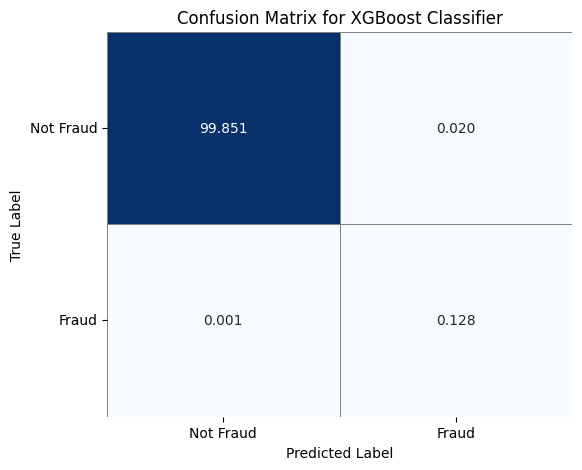

array([[1905948,     374],
       [     17,    2447]])

In [105]:
# Assuming you have y_test and predictions ready
# Calculate confusion matrix
cm = metrics.confusion_matrix(y_test, predictions)

# Calculate percentages for each cell
cm_percent = cm / cm.sum() * 100  # Percentage of total samples

plt.figure(figsize=(6,5))

# Plot heatmap with percentage annotations
sns.heatmap(
    cm_percent,
    annot=True,
    fmt='.3f',                # Two decimal places
    cmap='Blues',
    cbar=False,
    linewidths=0.5,
    linecolor='gray'
)

plt.xlabel('Predicted Label')
plt.ylabel('True Label')

plt.xticks(ticks=[0.5, 1.5], labels=['Not Fraud', 'Fraud'])
plt.yticks(ticks=[0.5, 1.5], labels=['Not Fraud', 'Fraud'], rotation = 0)

plt.title('Confusion Matrix for XGBoost Classifier')

plt.show()

cm



# ✅ Class Imbalance in LightGBM

In [55]:
# 1. Initialize model with class_weight handling for imbalance
model_lgbm = lgb.LGBMClassifier(class_weight='balanced')

# 2. Train on your training set
model_lgbm.fit(x_train, y_train)

# 3. Predict on the test set
y_pred_lgbm = model_lgbm.predict(x_test)

[LightGBM] [Info] Number of positive: 5749, number of negative: 4448085
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.052047 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2327
[LightGBM] [Info] Number of data points in the train set: 4453834, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000


In [56]:
lgbm_report = metrics.classification_report(y_test, y_pred_lgbm, output_dict=True)
lgbm_df = pd.DataFrame(lgbm_report).transpose()
lgbm_df

,precision,recall,f1-score,support
0,0.999997,0.999993,0.999995,1.906322e+06
1,0.994337,0.997565,0.995948,2.464000e+03
accuracy,0.999990,0.999990,0.999990,9.999895e-01
macro avg,0.997167,0.998779,0.997971,1.908786e+06
weighted avg,0.999990,0.999990,0.999990,1.908786e+06


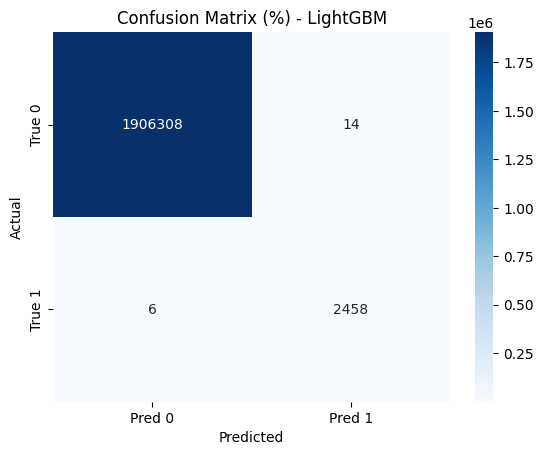

array([[1906308,      14],
       [      6,    2458]])

In [106]:
cm_lgbm = metrics.confusion_matrix(y_test, y_pred_lgbm)
#cm_lgbm_percentage = cm_lgbm / cm_lgbm.sum() * 100

# Plot heatmap
sns.heatmap(
    cm_lgbm,
    annot=True,
    fmt="d",
    cmap='Blues',
    xticklabels=['Pred 0', 'Pred 1'],
    yticklabels=['True 0', 'True 1']
)

plt.title("Confusion Matrix (%) - LightGBM")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

cm_lgbm

# Scale Data 
for Logistic Regression & Neural Network

In [67]:
data[selected_features].head()

,step,type,amount,oldbalanceOrg,oldbalanceDest,is_first_txn,time_since_last,AVG_txn_amount,total_past_amount,total_amount,is_outgoing,is_incoming,in_out_ratio,balance_change,insufficient_funds
3196942,249,1,244486.46,8946.00,526950.37,1,249.0,244486.46,0.00,244486.46,True,True,0.0,-235540.46,1
2798983,217,3,3170.28,58089.00,0.00,1,217.0,3170.28,244486.46,3170.28,True,False,0.0,54918.72,0
1013585,46,3,8424.74,783.00,0.00,1,46.0,8424.74,3170.28,8424.74,True,False,0.0,-7641.74,1
2980283,231,0,261877.19,7596.00,1126627.70,1,231.0,261877.19,8424.74,261877.19,True,True,0.0,-254281.19,1
1920204,167,0,20528.65,2302074.12,82696.17,1,167.0,20528.65,261877.19,20528.65,True,True,0.0,2281545.47,0


In [86]:


# Initialize OneHotEncoder
type_scaler = OneHotEncoder(sparse_output=False)  # sparse=False returns a dense array

# Fit and transform 'type' column (pass as 2D array)
type_scaled_array = type_scaler.fit_transform(data[['type']])

# Get new column names generated by the encoder
type_cols = type_scaler.get_feature_names_out(['type'])

# Create DataFrame from the encoded array with proper column names
type_df = pd.DataFrame(type_scaled_array, columns=type_cols, index=data.index)

# Concatenate the new one-hot columns to original data
data = pd.concat([data, type_df], axis=1)

# Drop the original 'type' column
data = data.drop(columns=['type'])

# Now data contains the one-hot encoded 'type' columns instead of original 'type'


In [89]:
data.head()

,step,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud,...,is_outgoing,is_incoming,in_out_ratio,balance_change,insufficient_funds,type_0,type_1,type_2,type_3,type_4
3196942,249,244486.46,C1000000639,8946.00,0.00,C785826240,526950.37,771436.84,0,0,...,1,1,0.0,-235540.46,1,0.0,1.0,0.0,0.0,0.0
2798983,217,3170.28,C1000001337,58089.00,54918.72,M216466820,0.00,0.00,0,0,...,1,0,0.0,54918.72,0,0.0,0.0,0.0,1.0,0.0
1013585,46,8424.74,C1000001725,783.00,0.00,M1974356374,0.00,0.00,0,0,...,1,0,0.0,-7641.74,1,0.0,0.0,0.0,1.0,0.0
2980283,231,261877.19,C1000002591,7596.00,269473.19,C503690069,1126627.70,864750.51,0,0,...,1,1,0.0,-254281.19,1,1.0,0.0,0.0,0.0,0.0
1920204,167,20528.65,C1000003372,2302074.12,2322602.77,C1840417793,82696.17,62167.52,0,0,...,1,1,0.0,2281545.47,0,1.0,0.0,0.0,0.0,0.0


In [88]:
data['is_outgoing'] = data['is_outgoing'].astype(int)
data['is_incoming'] = data['is_incoming'].astype(int)

In [ ]:

feature_for_scaled = [
    'step', 'amount',
    'oldbalanceOrg', 'oldbalanceDest',
    'time_since_last',
    'AVG_txn_amount', 'total_past_amount', 'total_amount',
     'in_out_ratio',
    'balance_change'
]
scaler = StandardScaler()
scaled_feature = scaler.fit_transform(data[feature_for_scaled])
scaled_cols = scaler.get_feature_names_out(feature_for_scaled)
scaled_feature_df = pd.DataFrame(scaled_feature, columns=scaled_cols, index=data.index)
data = data.drop(columns=['step', 'amount',
    'oldbalanceOrg', 'oldbalanceDest',
    'time_since_last',
    'AVG_txn_amount', 'total_past_amount', 'total_amount',
     'in_out_ratio',
    'balance_change'])
data = pd.concat([data, scaled_feature_df], axis=1)

In [90]:
feature_for_scaled = [
    'step', 'amount',
    'oldbalanceOrg', 'oldbalanceDest',
    'time_since_last',
    'AVG_txn_amount', 'total_past_amount', 'total_amount',
    'in_out_ratio',
    'balance_change'
]

scaler = StandardScaler()
scaled_feature = scaler.fit_transform(data[feature_for_scaled])

scaled_cols = [f"{col}_scaled" for col in feature_for_scaled]
scaled_feature_df = pd.DataFrame(scaled_feature, columns=scaled_cols, index=data.index)

data = data.drop(columns=feature_for_scaled)
data = pd.concat([data, scaled_feature_df], axis=1)


In [91]:
data.head()

,nameOrig,newbalanceOrig,nameDest,newbalanceDest,isFraud,isFlaggedFraud,hist_per_sender,prev_step,is_first_txn,is_outgoing,...,step_scaled,amount_scaled,oldbalanceOrg_scaled,oldbalanceDest_scaled,time_since_last_scaled,AVG_txn_amount_scaled,total_past_amount_scaled,total_amount_scaled,in_out_ratio_scaled,balance_change_scaled
3196942,C1000000639,0.00,C785826240,771436.84,0,0,0,0.0,1,1,...,0.039364,0.107019,-0.285619,-0.168791,0.041029,0.107126,-0.297924,0.105908,-0.001486,-0.301309
2798983,C1000001337,54918.72,M216466820,0.00,0,0,0,0.0,1,1,...,-0.185463,-0.292605,-0.268604,-0.323814,-0.183788,-0.292896,0.106458,-0.292878,-0.001486,-0.202926
1013585,C1000001725,0.00,M1974356374,0.00,0,0,0,0.0,1,1,...,-1.386879,-0.283903,-0.288445,-0.323814,-1.385153,-0.284185,-0.292681,-0.284195,-0.001486,-0.224116
2980283,C1000002591,269473.19,C503690069,864750.51,0,0,0,0.0,1,1,...,-0.087101,0.135819,-0.286086,0.007627,-0.085430,0.135954,-0.283990,0.134647,-0.001486,-0.307657
1920204,C1000003372,2322602.77,C1840417793,62167.52,0,0,0,0.0,1,1,...,-0.536754,-0.263859,0.508334,-0.299486,-0.535064,-0.264121,0.135223,-0.264193,-0.001486,0.551269


In [92]:
final_features = [
    'is_first_txn', 'is_outgoing', 'is_incoming', 'insufficient_funds',
    'type_0', 'type_1', 'type_2', 'type_3', 'type_4',  
    'step_scaled', 'amount_scaled', 'oldbalanceOrg_scaled', 'oldbalanceDest_scaled',
    'time_since_last_scaled', 'AVG_txn_amount_scaled', 'total_past_amount_scaled',
    'total_amount_scaled', 'in_out_ratio_scaled', 'balance_change_scaled'
]

# 2. Define X (features) and y (target)
x = data[final_features]
y = data['isFraud']

# 3. Split into train/test sets (70% train, 30% test)
x_train, x_test, y_train, y_test = train_test_split(
    x, y, 
    test_size=0.30, 
    random_state=42, 
    stratify=y  #  recommended due to class imbalance
)



# Logistic Regression

In [94]:
lreg_model = LogisticRegression(class_weight='balanced')  #This tells the model to automatically adjust weights inversely proportional to class frequencies, which is great for your imbalanced fraud dataset.
lreg_model.fit(x_train, y_train)
y_pred_lreg = lreg_model.predict(x_test)


In [100]:
lreg_report = metrics.classification_report(y_test, y_pred_lreg, output_dict=True)
lreg_report_df = pd.DataFrame(lreg_report).transpose()
lreg_report_df

,precision,recall,f1-score,support
0,0.999997,0.956669,0.977853,1.906322e+06
1,0.028897,0.997565,0.056167,2.464000e+03
accuracy,0.956722,0.956722,0.956722,9.567217e-01
macro avg,0.514447,0.977117,0.517010,1.908786e+06
weighted avg,0.998743,0.956722,0.976663,1.908786e+06


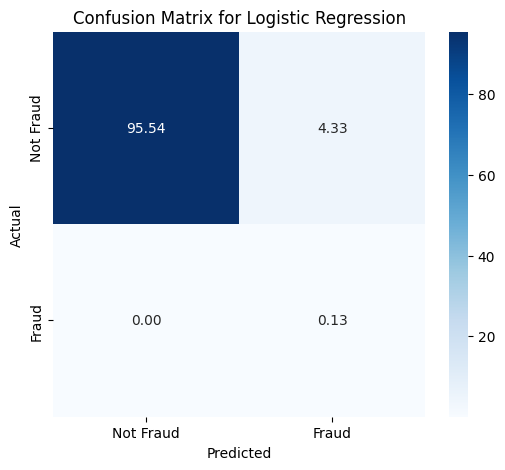

array([[1823719,   82603],
       [      6,    2458]])

In [104]:
# Confusion_Matrix
cm = metrics.confusion_matrix(y_test, y_pred_lreg)

cm_percent = cm / cm.sum() * 100  # Percentage of total samples
plt.figure(figsize=(6,5))
sns.heatmap(
    cm_percent,
    cmap='Blues',
    annot=True,
    fmt='.2f',             # Display numbers as integers
    xticklabels=['Not Fraud', 'Fraud'],  # Customize labels
    yticklabels=['Not Fraud', 'Fraud']
)

plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix for Logistic Regression')
plt.show()
cm